<a href="https://colab.research.google.com/github/joaosMart/fish-species-class-siglip/blob/main/Code/Multi_Fish_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Fish Detection: Prompt Engineering and Evaluation

Implementation of zero-shot multi-fish detection using SigLIP vision-language models

Associated with: "Temporal Aggregation of Vision-Language Features for High-Accuracy Fish Classification in Automated Monitoring"


In [1]:
# Install required packages (uncomment if running in Colab)
!pip install transformers open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [20]:
import os
import torch
import torch.nn.functional as F
import open_clip
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import glob
from scipy.ndimage import uniform_filter1d
from matplotlib.font_manager import FontProperties
import warnings

warnings.filterwarnings('ignore')

In [21]:
# Configuration
MODEL_NAME = "ViT-SO400M-14-SigLIP"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
print(f"Using model: {MODEL_NAME}")

Using device: cuda
Using model: ViT-SO400M-14-SigLIP


## Model Initialization

In [22]:
def initialize_model():
    """Initialize SigLIP model and preprocessing pipeline"""
    model, _, preprocess_val = open_clip.create_model_and_transforms(
        MODEL_NAME, pretrained="webli"
    )
    tokenizer = open_clip.get_tokenizer(MODEL_NAME)
    model = model.to(DEVICE)
    return model, preprocess_val, tokenizer

## Data Loading

In [24]:
#

def setup_dataset():
    """Setup instructions for downloading the dataset."""

    if os.path.exists("fish_dataset"):
        print("✅ Dataset already exists!")
        return True

    print("📋 DATASET SETUP REQUIRED:")
    print("1. Go to: https://drive.google.com/drive/folders/13Q2YsdajGGiR3UzDW8_zdcwAunMZRGzb?usp=sharing")
    print("2. Right-click the folder → Download")
    print("3. Google Drive will automatically create a ZIP file")
    print("4. Upload the ZIP to Colab using the file upload button")
    print("5. Run the extraction cell below")

    return False

def extract_uploaded_dataset(path_to_zip):
    """Extract dataset after manual upload."""

    from google.colab import files
    import zipfile


    # Extract
    with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
        zip_ref.extractall("./multi_fish_detection_data")

    # Remove ZIP
    os.remove(path_to_zip)
    print("✅ Dataset extracted!")

# Usage in your notebook:
if not setup_dataset():
    # If dataset doesn't exist, show upload option
    extract_uploaded_dataset("/content/validation_fish_counting-20250804T192910Z-1-001.zip")


📋 DATASET SETUP REQUIRED:
1. Go to: https://drive.google.com/drive/folders/13Q2YsdajGGiR3UzDW8_zdcwAunMZRGzb?usp=sharing
2. Right-click the folder → Download
3. Google Drive will automatically create a ZIP file
4. Upload the ZIP to Colab using the file upload button
5. Run the extraction cell below
✅ Dataset extracted!


In [25]:
def load_data_paths():
    """Load paths to multi-fish and single-fish image datasets

    Note: Update these paths to point to your local dataset
    """
    # Replace these paths with your local dataset paths
    multiple_fish_paths = glob.glob("multi_fish_detection_data/validation_fish_counting/more_than_one_fish/*.jpg")
    single_fish_paths = glob.glob("multi_fish_detection_data/validation_fish_counting/one_fish/*.jpg")

    print(f"Loaded {len(multiple_fish_paths)} multiple fish images")
    print(f"Loaded {len(single_fish_paths)} single fish images")

    return multiple_fish_paths, single_fish_paths

## Prompt Definitions

In [26]:
# Carefully engineered prompts for multiple fish detection
MULTIPLE_FISH_PROMPTS = [
    "Salmon-like fishes swimming",
    "An image of more than one salmon-like fish seen clearly swimming.",
    "Image of salmon-like fishes in a contained environment.",
    "Image of multiple salmon-like fish in a contained environment.",
    "Image of two or more salmon-like fish in a contained environment.",
    "Image of fishes swimming in a confined water space.",
    "Clear image of multiple fish swimming in a river.",
    "Image of more than one salmon-like fish in a contained environment."
]

SINGLE_FISH_PROMPTS = [
    "Salmon-like fish swimming",
    "An underwater photo of a salmon-like fish seen clearly swimming.",
    "Image of a single salmon-like fish in a contained environment.",
    "A photo of a salmon-like fish in a controlled river environment.",
    "Image of one fish swimming in a confined water space.",
    "Clear image of a single fish swimming in a river.",
    "Clear image of a single fish swimming in a contained environment.",
    "Image of one salmon-like fish in a contained environment."
]

NEGATIVE_PROMPTS = [
    "A container in a river with nothing in it.",
    "An image of an empty white water container.",
    "An underwater photo of a confined water space with nothing in it.",
    "A photo of a confined water space with nothing in it.",
    "A photo of an empty confined white water space.",
    "An image of a controlled environment with nothing in it.",
    "Controlled river environment free from fish.",
    "A contained environment with nothing in it.",
    "An image of a empty container with nothing in it."
]

# Best performing prompts identified through evaluation
CHOSEN_MULTIPLE_PROMPTS = [
    "Salmon-like fishes swimming",
    "Image of two or more salmon-like fish in a contained environment."
]

CHOSEN_SINGLE_PROMPTS = [
    "Clear image of a single fish swimming in a river.",
    "Clear image of a single fish swimming in a contained environment."
]

CHOSEN_NEGATIVE_PROMPTS = [
    "An image of an empty white water container.",
    "A contained environment with nothing in it.",
    "An image of a empty container with nothing in it."
]

## Feature Extraction

In [27]:

def compute_average_embedding(prompts, model, tokenizer, device):
    """Compute average embedding for a set of prompts"""
    text = tokenizer(prompts, context_length=model.context_length).to(device)
    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = F.normalize(model.encode_text(text), dim=-1)
    return torch.mean(text_features, dim=0, keepdim=True)

def process_images_batch(image_paths, model, preprocess_val, text_features_dict, batch_size=32):
    """Process images in batches and compute similarity scores"""
    results = []

    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]

        # Load and preprocess images
        try:
            images = torch.stack([
                preprocess_val(Image.open(img_path)).to(DEVICE)
                for img_path in batch_paths
            ])
        except Exception as e:
            print(f"Error processing batch starting at {i}: {e}")
            continue

        # Compute image features
        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = F.normalize(model.encode_image(images), dim=-1)

            # Compute similarities for different prompt sets
            multiple_similarities = (100.0 * image_features @ text_features_dict['multiple_prompts_probabilities'].T).cpu().numpy()
            single_similarities = (100.0 * image_features @ text_features_dict['single_prompts_probabilities'].T).cpu().numpy()
            negative_similarities = (100.0 * image_features @ text_features_dict['negative_prompts_probabilities'].T).cpu().numpy()

            # Compute average embeddings
            avg_multiple_scores = (100.0 * image_features @ text_features_dict['avg_multiple_score'].T).cpu().numpy()
            avg_single_scores = (100.0 * image_features @ text_features_dict['avg_single_score'].T).cpu().numpy()
            avg_negative_scores = (100.0 * image_features @ text_features_dict['avg_negative_score'].T).cpu().numpy()

            # Store results for each image in batch
            for j, img_path in enumerate(batch_paths):
                result = {
                    'image_path': img_path,
                    'multiple_prompts_probabilities': multiple_similarities[j],
                    'single_prompts_probabilities': single_similarities[j],
                    'negative_prompts_probabilities': negative_similarities[j],
                    'avg_multiple_score': avg_multiple_scores[j, 0],
                    'avg_single_score': avg_single_scores[j, 0],
                    'avg_negative_score': avg_negative_scores[j, 0]
                }
                results.append(result)

        # Clear CUDA cache
        torch.cuda.empty_cache()

    return results

## Evaluation and Plotting Functions

In [28]:
def wrap_legend_labels(label, wrap_length=40):
    """Wrap legend labels for better readability"""
    if len(label) <= wrap_length:
        return label
    words = label.split()
    lines = []
    current_line = []
    current_length = 0
    for word in words:
        if current_length + len(word) > wrap_length:
            lines.append(' '.join(current_line))
            current_line = [word]
            current_length = len(word)
        else:
            current_line.append(word)
            current_length += len(word) + 1
    if current_line:
        lines.append(' '.join(current_line))
    return '\n'.join(lines)

def plot_roc_curves(results, prompts, class_name, output_filename, chosen_prompts,
                   positive_class=1):
    """Plot ROC curves comparing individual prompts and ensemble performance"""
    plt.figure(figsize=(14, 8))
    plt.rcParams.update({'font.size': 16})
    ax = plt.gca()
    for spine in ['top', 'right', 'left', 'bottom']:
        ax.spines[spine].set_visible(False)

    # Extract true labels based on file paths
    true_labels = []
    for r in results:
        if 'more_than_one_fish' in r['image_path'] or 'more than one fish' in r['image_path']:
            true_labels.append(1)  # Multiple fish
        else:
            true_labels.append(0)  # Single fish

    true_labels = np.array(true_labels)

    # Adjust for single fish detection (invert labels)
    if positive_class == 0:
        true_labels = 1 - true_labels

    bold_font = FontProperties(weight='bold')
    lines, labels = [], []

    # Plot individual prompts
    prompt_key = f'{class_name}_prompts_probabilities'
    if prompt_key in results[0]:
        for i, prompt in enumerate(prompts):
            try:
                # Extract scores for this specific prompt
                scores = np.array([r[prompt_key][i] for r in results])

                auc = roc_auc_score(true_labels, scores)
                fpr, tpr, _ = roc_curve(true_labels, scores)

                label = f"★ {prompt}" if prompt in chosen_prompts else prompt
                wrapped_label = wrap_legend_labels(f"{label} (AUC = {auc:.2f})", 40)
                line = plt.plot(fpr, tpr, label=wrapped_label, alpha=0.7)[0]
                lines.append(line)
                labels.append(wrapped_label)

            except (IndexError, ValueError) as e:
                print(f"Skipping prompt {i} due to error: {e}")
                continue

    # Plot ensemble performance
    avg_key = f'avg_{class_name}_score'
    if avg_key in results[0]:
        try:
            avg_scores = np.array([r[avg_key] for r in results])
            avg_auc = roc_auc_score(true_labels, avg_scores)
            avg_fpr, avg_tpr, _ = roc_curve(true_labels, avg_scores)
            avg_line = plt.plot(avg_fpr, avg_tpr, color='black', linewidth=2,
                              label=f'Ensemble (AUC = {avg_auc:.2f})')[0]
            lines.append(avg_line)
            labels.append(f'Ensemble (AUC = {avg_auc:.2f})')
        except (ValueError, KeyError) as e:
            print(f"Could not plot ensemble curve: {e}")

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {class_name.title()} Fish Detection')

    # Create legend
    if lines:
        legend = plt.legend(lines, labels, loc="upper left", bbox_to_anchor=(1, 1),
                           frameon=False)
        for i, text in enumerate(legend.get_texts()):
            if i < len(prompts) and prompts[i] in chosen_prompts:
                text.set_fontproperties(bold_font)

    plt.grid(True, linestyle='-', alpha=0.5)
    plt.tight_layout()
    plt.savefig(output_filename, dpi=300, bbox_inches='tight', format='pdf')
    plt.show()

    print(f"ROC curve saved as {output_filename}")

def plot_similarity_scores(results, prompts, class_name, output_filename,
                          chosen_prompts, window_size=15):
    """Plot similarity score distributions with smoothing"""
    prompt_key = f'{class_name}_prompts_probabilities'
    avg_key = f'avg_{class_name}_score'

    if not results or prompt_key not in results[0]:
        print(f"No data available for {class_name} similarity scores")
        return

    try:
        probabilities = np.array([r[prompt_key] for r in results], dtype=np.float32)
        avg_scores = np.array([r[avg_key] for r in results], dtype=np.float32)

        # Apply smoothing
        data_denoised = np.array([
            uniform_filter1d(probabilities[:, i], size=min(window_size, len(probabilities)))
            for i in range(probabilities.shape[1])
        ]).T
        avg_scores_denoised = uniform_filter1d(avg_scores, size=min(window_size, len(avg_scores)))

        plt.figure(figsize=(12, 6))
        plt.rcParams.update({'font.size': 16})

        bold_font = FontProperties(weight='bold')
        lines, labels = [], []

        # Plot individual prompts
        for i, prompt in enumerate(prompts):
            if i < data_denoised.shape[1]:
                label = f"★ {prompt}" if prompt in chosen_prompts else prompt
                wrapped_label = wrap_legend_labels(label, 40)
                line = plt.plot(data_denoised[:, i], label=wrapped_label, alpha=0.7)[0]
                lines.append(line)
                labels.append(wrapped_label)

        # Plot ensemble
        avg_line = plt.plot(avg_scores_denoised, color='black', linewidth=2,
                           label='Ensemble')[0]
        lines.append(avg_line)
        labels.append('Ensemble')

        # Add class separation line for multiple fish detection
        if class_name == 'multiple':
            multiple_count = len([r for r in results
                                if 'more_than_one_fish' in r['image_path'] or 'more than one fish' in r['image_path']])
            if multiple_count > 0 and multiple_count < len(results):
                plt.axvline(x=multiple_count, color='black', linestyle='--')
                plt.text(multiple_count/2, np.max(data_denoised) * 0.99,
                        'Multiple Fish', ha='center')
                plt.text(multiple_count + (len(results) - multiple_count)/2,
                        np.max(data_denoised) * 0.99, 'Single Fish', ha='center')

        # Create legend
        if lines:
            legend = plt.legend(lines, labels, loc='upper left', bbox_to_anchor=(1, 1),
                               frameon=False)
            for i, text in enumerate(legend.get_texts()):
                if i < len(prompts) and prompts[i] in chosen_prompts:
                    text.set_fontproperties(bold_font)

        plt.xlabel('Data Samples')
        plt.ylabel('Similarity Scores')
        plt.title(f'Similarity Score Distribution - {class_name.title()} Fish Detection')
        plt.grid(True, linestyle='-', alpha=0.5)

        ax = plt.gca()
        for spine in ['top', 'right', 'bottom', 'left']:
            ax.spines[spine].set_visible(False)

        plt.savefig(output_filename, dpi=300, bbox_inches='tight', format='pdf')
        plt.show()

        print(f"Similarity scores plot saved as {output_filename}")

    except Exception as e:
        print(f"Error plotting similarity scores for {class_name}: {e}")
        return

## Code Execution

=== Multi-Fish Detection: Prompt Engineering ===
Paper: Temporal Aggregation of Vision-Language Features for High-Accuracy Fish Classification

1. Initializing SigLIP model...
2. Loading dataset...
Loaded 100 multiple fish images
Loaded 100 single fish images
3. Encoding text prompts...
4. Processing images and computing similarities...
Processed 200 images successfully
5. Generating evaluation plots...


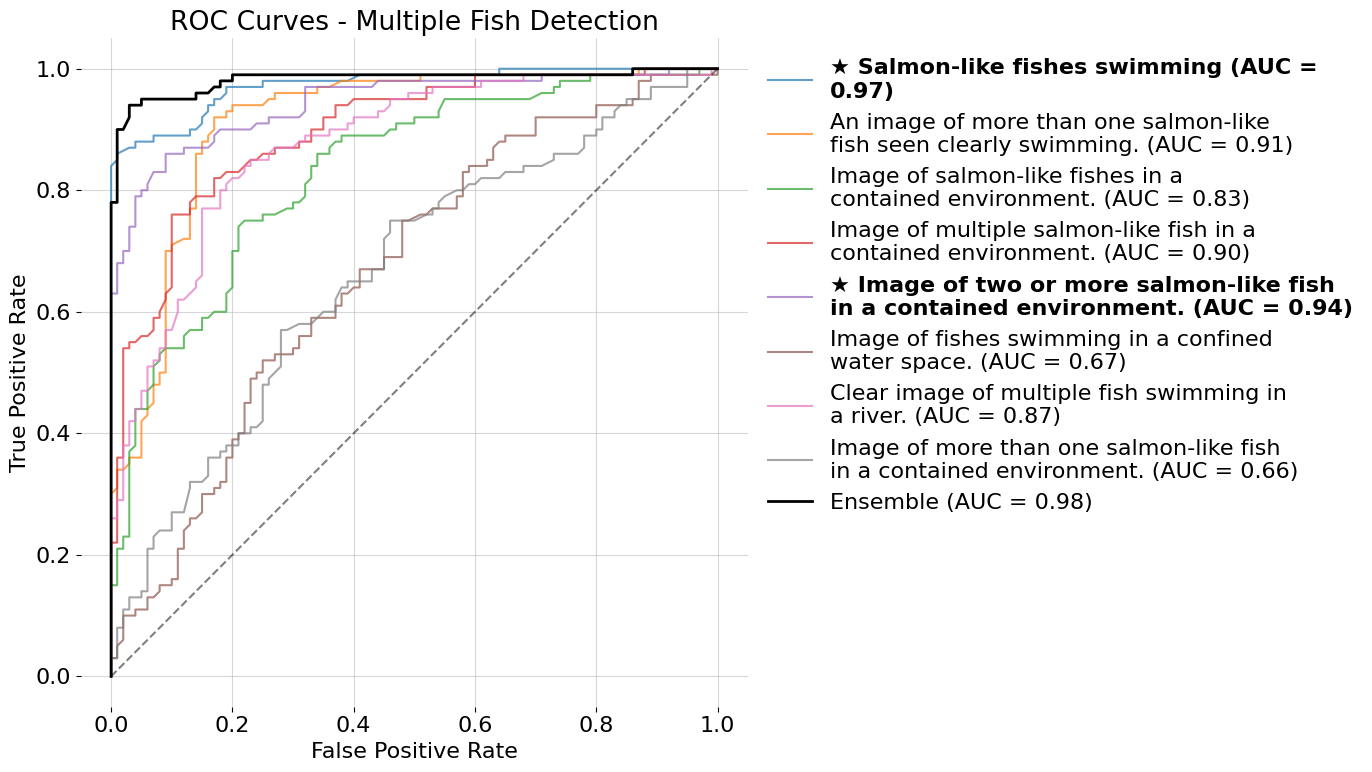

ROC curve saved as multiple_fish_ROC.pdf


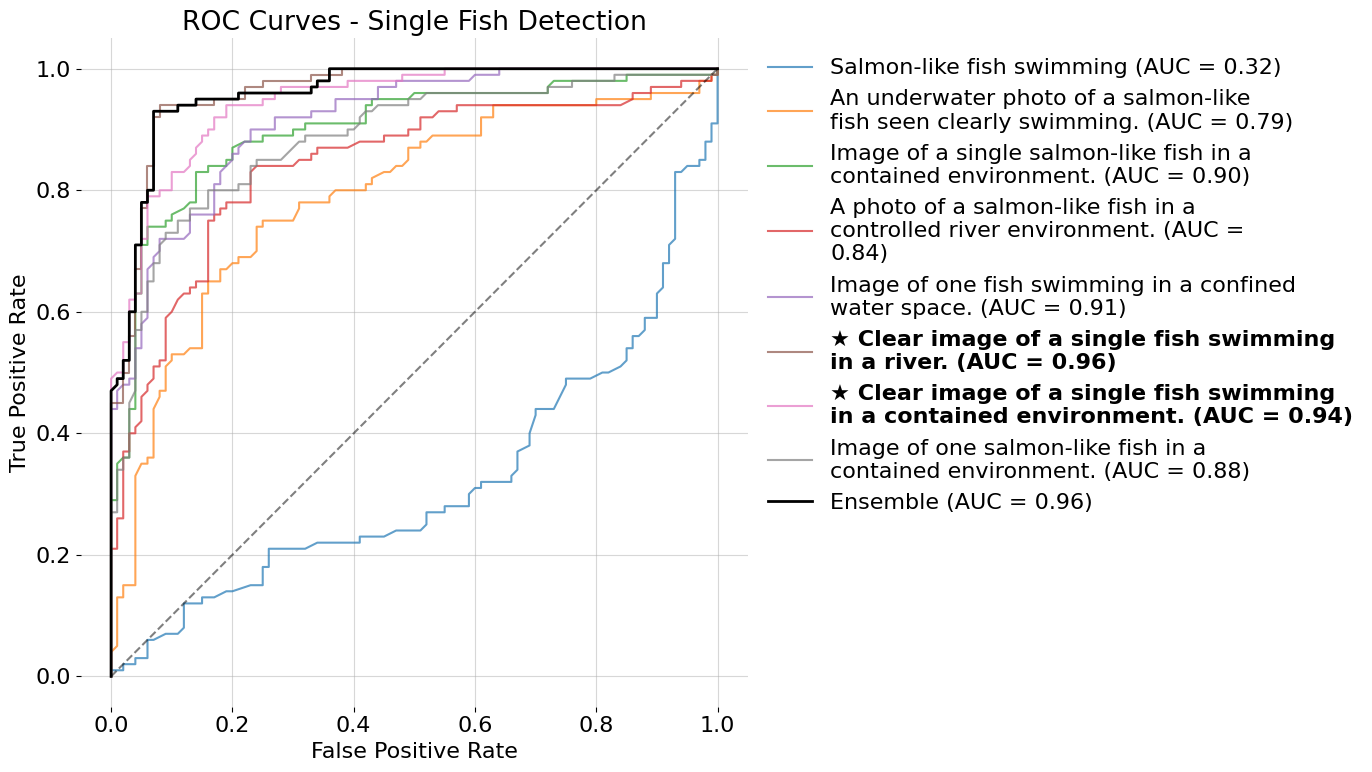

ROC curve saved as single_fish_ROC.pdf


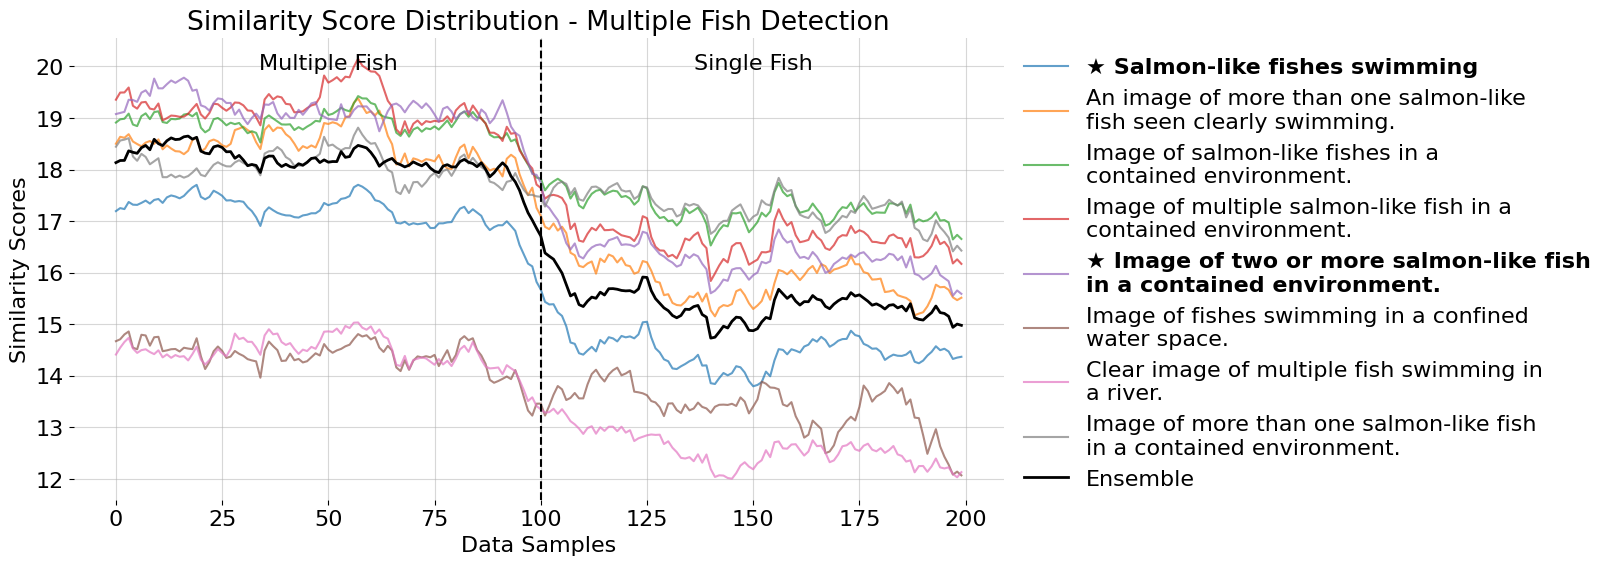

Similarity scores plot saved as multiple_prompt_similarity.pdf


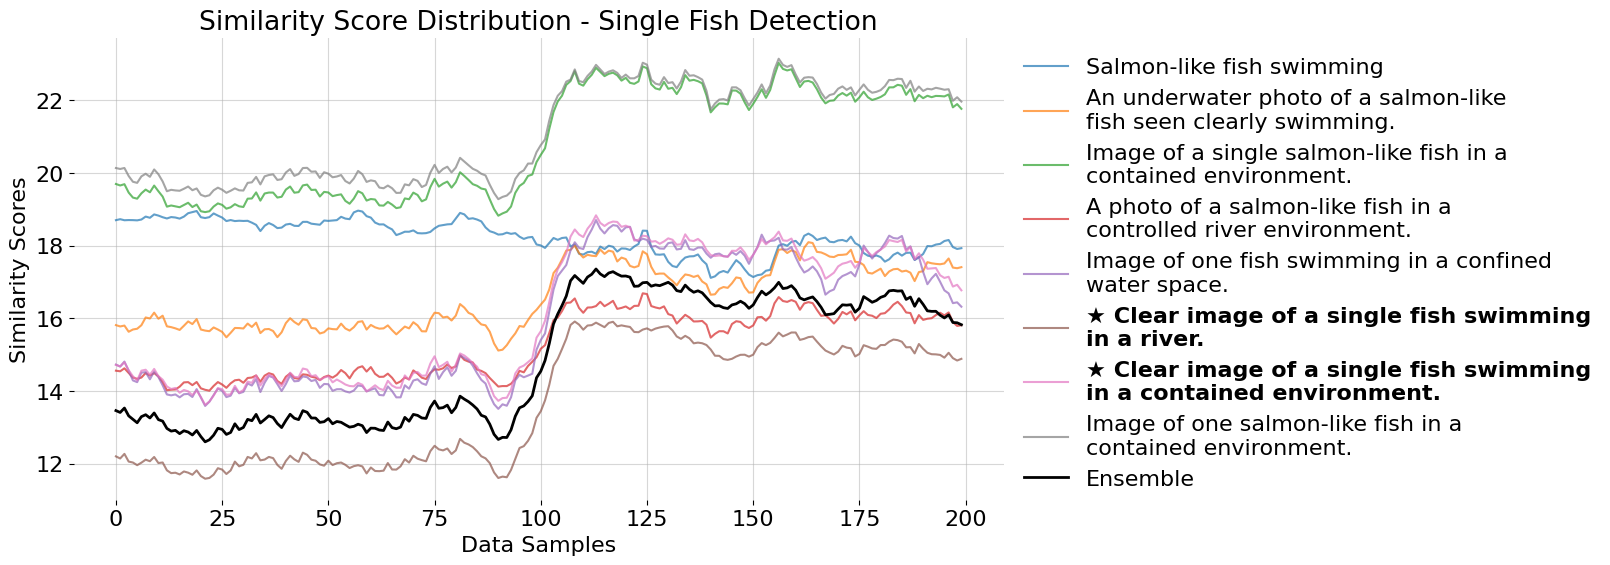

Similarity scores plot saved as single_prompt_similarity.pdf

6. Performance Summary:
Selected prompts based on ROC analysis:
Multiple fish: ['Salmon-like fishes swimming', 'Image of two or more salmon-like fish in a contained environment.']
Single fish: ['Clear image of a single fish swimming in a river.', 'Clear image of a single fish swimming in a contained environment.']
Negative (no fish): ['An image of an empty white water container.', 'A contained environment with nothing in it.', 'An image of a empty container with nothing in it.']

Prompt engineering complete! Check the generated PDF files for detailed results.


In [29]:
def main():
    """Main execution function for multi-fish detection prompt engineering"""
    print("=== Multi-Fish Detection: Prompt Engineering ===")
    print("Paper: Temporal Aggregation of Vision-Language Features for High-Accuracy Fish Classification")
    print()

    # Initialize model
    print("1. Initializing SigLIP model...")
    model, preprocess_val, tokenizer = initialize_model()

    # Load data
    print("2. Loading dataset...")
    multiple_fish_paths, single_fish_paths = load_data_paths()

    if not multiple_fish_paths or not single_fish_paths:
        print("Error: No images found. Please update the data paths in load_data_paths()")
        return

    # Encode text prompts
    print("3. Encoding text prompts...")

    # Individual prompt features
    m_text = tokenizer(MULTIPLE_FISH_PROMPTS, context_length=model.context_length).to(DEVICE)
    s_text = tokenizer(SINGLE_FISH_PROMPTS, context_length=model.context_length).to(DEVICE)
    n_text = tokenizer(NEGATIVE_PROMPTS, context_length=model.context_length).to(DEVICE)

    with torch.no_grad(), torch.cuda.amp.autocast():
        m_text_features = F.normalize(model.encode_text(m_text), dim=-1)
        s_text_features = F.normalize(model.encode_text(s_text), dim=-1)
        n_text_features = F.normalize(model.encode_text(n_text), dim=-1)

    # Average embeddings for chosen prompts
    avg_multiple_embedding = compute_average_embedding(CHOSEN_MULTIPLE_PROMPTS, model, tokenizer, DEVICE)
    avg_single_embedding = compute_average_embedding(CHOSEN_SINGLE_PROMPTS, model, tokenizer, DEVICE)
    avg_negative_embedding = compute_average_embedding(CHOSEN_NEGATIVE_PROMPTS, model, tokenizer, DEVICE)

    # Organize features
    text_features_dict = {
        'multiple_prompts_probabilities': m_text_features,
        'single_prompts_probabilities': s_text_features,
        'negative_prompts_probabilities': n_text_features,
        'avg_multiple_score': avg_multiple_embedding,
        'avg_single_score': avg_single_embedding,
        'avg_negative_score': avg_negative_embedding
    }

    # Process images
    print("4. Processing images and computing similarities...")
    all_image_paths = multiple_fish_paths + single_fish_paths
    results = process_images_batch(all_image_paths, model, preprocess_val, text_features_dict)

    print(f"Processed {len(results)} images successfully")

    # Generate evaluation plots
    print("5. Generating evaluation plots...")

    # ROC curves
    plot_roc_curves(results, MULTIPLE_FISH_PROMPTS, 'multiple',
                   'multiple_fish_ROC.pdf', CHOSEN_MULTIPLE_PROMPTS)
    plot_roc_curves(results, SINGLE_FISH_PROMPTS, 'single',
                   'single_fish_ROC.pdf', CHOSEN_SINGLE_PROMPTS, positive_class=0)

    # Similarity score distributions
    plot_similarity_scores(results, MULTIPLE_FISH_PROMPTS, 'multiple',
                          'multiple_prompt_similarity.pdf', CHOSEN_MULTIPLE_PROMPTS)
    plot_similarity_scores(results, SINGLE_FISH_PROMPTS, 'single',
                          'single_prompt_similarity.pdf', CHOSEN_SINGLE_PROMPTS)

    # Performance summary
    print("\n6. Performance Summary:")
    print("Selected prompts based on ROC analysis:")
    print("Multiple fish:", CHOSEN_MULTIPLE_PROMPTS)
    print("Single fish:", CHOSEN_SINGLE_PROMPTS)
    print("Negative (no fish):", CHOSEN_NEGATIVE_PROMPTS)

    print("\nPrompt engineering complete! Check the generated PDF files for detailed results.")
    return results

if __name__ == "__main__":
    # Execute main function
    results = main()

# Multi-Fish Detection: Cross-Validation and Threshold Optimization

Rigorous evaluation of zero-shot multi-fish detection performance

Associated with: "Temporal Aggregation of Vision-Language Features for High-Accuracy Fish Classification in Automated Monitoring"

In [30]:
import torch
import torch.nn.functional as F
import open_clip
from PIL import Image
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, auc, confusion_matrix)
from sklearn.model_selection import RepeatedStratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [31]:
# Configuration
MODEL_NAME = 'ViT-SO400M-14-SigLIP'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 42

# Cross-validation parameters
N_SPLITS = 5
N_REPEATS = 30
TOTAL_CV_ITERATIONS = N_SPLITS * N_REPEATS

print(f"Using device: {DEVICE}")
print(f"Cross-validation setup: {N_SPLITS}-fold, {N_REPEATS} repeats = {TOTAL_CV_ITERATIONS} total evaluations")

Using device: cuda
Cross-validation setup: 5-fold, 30 repeats = 150 total evaluations


## Data Loading and Preparation

In [39]:
def load_and_preprocess_data():
    """Load multi-fish and single-fish datasets

    Returns:
        image_paths: List of image file paths
        labels: List of binary labels (1=multiple fish, 0=single fish)
    """
    # Replace these paths with your local dataset paths
    multiple_fish = glob.glob("/content/multi_fish_detection_data/validation_fish_counting/more_than_one_fish/*.jpg")
    single_fish = glob.glob("/content/multi_fish_detection_data/validation_fish_counting/one_fish/*.jpg")

    image_paths = multiple_fish + single_fish
    labels = [1] * len(multiple_fish) + [0] * len(single_fish)

    print(f"Dataset loaded:")
    print(f"  Multiple fish images: {len(multiple_fish)}")
    print(f"  Single fish images: {len(single_fish)}")
    print(f"  Total images: {len(image_paths)}")
    print(f"  Class distribution: {len(multiple_fish)/(len(multiple_fish)+len(single_fish))*100:.1f}% multiple fish")

    return image_paths, labels

## Prompt Configuration

In [33]:
def setup_prompts_and_features(model, tokenizer, device):
    """Setup optimized prompts and compute text features

    These prompts were selected based on ROC analysis (see companion notebook)
    """
    # Best performing prompts from prompt engineering analysis
    multiple_fish_prompts = [
        "Salmon-like fishes swimming",
        "Image of two or more salmon-like fish in a contained environment."
    ]

    single_fish_prompt = "Clear image of a single fish swimming in a river."

    print("Using optimized prompts:")
    print(f"  Multiple fish: {multiple_fish_prompts}")
    print(f"  Single fish: {single_fish_prompt}")

    # Encode prompts
    with torch.no_grad():
        multiple_fish_features = model.encode_text(
            tokenizer(multiple_fish_prompts).to(device)
        )
        single_fish_feature = model.encode_text(
            tokenizer([single_fish_prompt]).to(device)
        )

    # Calculate mean embedding for multiple fish prompts
    multiple_fish_mean = torch.mean(multiple_fish_features, dim=0, keepdim=True)

    # Combine features: [multiple_fish_mean, single_fish]
    text_features = torch.cat([multiple_fish_mean, single_fish_feature], dim=0)
    text_features = F.normalize(text_features, dim=-1)

    return text_features

## Inference and Evaluation

In [34]:
def apply_clip_model(model, image_paths, text_features, preprocess_val, device, batch_size=128):
    """Apply CLIP model to images and compute similarity scores

    Returns:
        probabilities for multiple fish class (index 0)
    """
    all_probs = []

    for batch_start in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[batch_start:batch_start+batch_size]

        try:
            images = torch.stack([
                preprocess_val(Image.open(img_path)).to(device)
                for img_path in batch_paths
            ])
        except Exception as e:
            print(f"Error processing batch at {batch_start}: {e}")
            # Fill with zeros for failed images
            all_probs.extend([0.0] * len(batch_paths))
            continue

        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(images)
            image_features = F.normalize(image_features, dim=-1)

            # Compute softmax probabilities
            text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

            # Extract probability for multiple fish class (index 0)
            batch_probs = text_probs[:, 0].cpu().numpy()
            all_probs.extend(batch_probs)

    return np.array(all_probs)

def compute_metrics(y_true, y_pred):
    """Compute standard classification metrics"""
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }

def optimize_threshold(outputs, labels):
    """Find optimal threshold that maximizes F1-score"""
    thresholds = np.linspace(0.0, 1.0, 1000)
    best_f1 = 0
    best_threshold = 0.5

    for threshold in thresholds:
        y_pred = (outputs >= threshold).astype(int)
        f1 = f1_score(labels, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold

## Cross-Validation Framework

In [35]:
def perform_cross_validation(image_paths, labels, model, text_features, preprocess_val, device):
    """Perform rigorous cross-validation evaluation

    Uses RepeatedStratifiedKFold to ensure:
    - Balanced class distribution in each fold
    - Multiple repetitions for robust statistics
    - Video-level splits to avoid temporal correlation
    """
    cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_SEED)

    all_metrics = []
    all_thresholds = []
    all_true_labels = []
    all_predictions = []

    print(f"\nStarting cross-validation: {TOTAL_CV_ITERATIONS} iterations...")

    cv_iterator = list(cv.split(image_paths, labels))

    for fold_idx, (train_index, test_index) in enumerate(tqdm(cv_iterator, desc="CV Progress")):
        # Split data
        X_train = [image_paths[i] for i in train_index]
        X_test = [image_paths[i] for i in test_index]
        y_train = [labels[i] for i in train_index]
        y_test = [labels[i] for i in test_index]

        # Get model outputs
        train_outputs = apply_clip_model(model, X_train, text_features, preprocess_val, device)
        test_outputs = apply_clip_model(model, X_test, text_features, preprocess_val, device)

        # Optimize threshold on training set
        best_threshold = optimize_threshold(train_outputs, y_train)
        all_thresholds.append(best_threshold)

        # Apply threshold to test set
        y_pred_test = (test_outputs >= best_threshold).astype(int)

        # Compute metrics
        metrics = compute_metrics(y_test, y_pred_test)
        all_metrics.append(metrics)

        # Store for ROC analysis
        all_true_labels.append(y_test)
        all_predictions.append(test_outputs)

    # Compute aggregated statistics
    mean_metrics = {k: np.mean([m[k] for m in all_metrics]) for k in all_metrics[0].keys()}
    std_metrics = {k: np.std([m[k] for m in all_metrics]) for k in all_metrics[0].keys()}

    return mean_metrics, std_metrics, all_metrics, all_thresholds, all_true_labels, all_predictions


## Visualization Functions

In [41]:


def plot_metrics_vs_thresholds(all_true_labels, all_predictions, all_thresholds):
    """Plot classification metrics across different threshold values"""
    # Flatten predictions
    y_true = np.concatenate(all_true_labels)
    y_scores = np.concatenate(all_predictions)

    thresholds = np.linspace(0, 1, 1000)
    precisions, recalls, accuracies, f1_scores = [], [], [], []

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        precisions.append(precision_score(y_true, y_pred, zero_division=0))
        recalls.append(recall_score(y_true, y_pred, zero_division=0))
        accuracies.append(accuracy_score(y_true, y_pred))
        f1_scores.append(f1_score(y_true, y_pred, zero_division=0))

    mean_threshold = np.mean(all_thresholds)
    median_threshold = np.median(all_thresholds)

    plt.figure(figsize=(12, 8))
    plt.plot(thresholds, precisions, label='Precision', linewidth=2)
    plt.plot(thresholds, recalls, label='Recall', linewidth=2)
    plt.plot(thresholds, accuracies, label='Accuracy', linewidth=2)
    plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2)

    # Add vertical lines for mean and median thresholds
    plt.axvline(mean_threshold, color='r', linestyle='--', linewidth=2,
                label=f'Mean Threshold: {mean_threshold:.4f}')
    plt.axvline(median_threshold, color='g', linestyle='-.', linewidth=2,
                label=f'Median Threshold: {median_threshold:.4f}')

    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel('Score', fontsize=14)
    plt.title('Classification Metrics vs Threshold', fontsize=16)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True, alpha=0.3)

    # Remove spines for cleaner look
    ax = plt.gca()
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.savefig("metrics_vs_thresholds.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Print metric values at optimal thresholds
    print(f"\nMetrics at Mean Threshold ({mean_threshold:.4f}):")
    print(f"  Precision: {np.interp(mean_threshold, thresholds, precisions):.4f}")
    print(f"  Recall: {np.interp(mean_threshold, thresholds, recalls):.4f}")
    print(f"  Accuracy: {np.interp(mean_threshold, thresholds, accuracies):.4f}")
    print(f"  F1 Score: {np.interp(mean_threshold, thresholds, f1_scores):.4f}")


def plot_threshold_distribution(all_thresholds):
    """Plot distribution of optimal thresholds across CV folds"""
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create histogram
    counts, bins, _ = ax.hist(all_thresholds, bins=30, density=True, alpha=0.7,
                             color='skyblue', edgecolor='black')

    # Add KDE curve
    sns.kdeplot(all_thresholds, color="crimson", ax=ax, linewidth=2)

    # Calculate statistics
    mean_threshold = np.mean(all_thresholds)
    median_threshold = np.median(all_thresholds)
    std_threshold = np.std(all_thresholds)

    # Add vertical lines for statistics
    ax.axvline(mean_threshold, color='r', linestyle='--', linewidth=2,
               label=f'Mean: {mean_threshold:.4f}')
    ax.axvline(median_threshold, color='g', linestyle='-.', linewidth=2,
               label=f'Median: {median_threshold:.4f}')

    ax.set_title('Distribution of Optimal Thresholds Across CV Folds', fontsize=16)
    ax.set_xlabel('Threshold', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)

    # Remove spines
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.savefig("threshold_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Print detailed statistics
    print(f"\nThreshold Distribution Statistics:")
    print(f"  Mean: {mean_threshold:.4f}")
    print(f"  Median: {median_threshold:.4f}")
    print(f"  Standard Deviation: {std_threshold:.4f}")
    print(f"  5th Percentile: {np.percentile(all_thresholds, 5):.4f}")
    print(f"  95th Percentile: {np.percentile(all_thresholds, 95):.4f}")
    print(f"  Range: [{np.min(all_thresholds):.4f}, {np.max(all_thresholds):.4f}]")

def plot_roc_curve(all_true_labels, all_predictions):
    """Plot ROC curve with confidence intervals"""
    plt.figure(figsize=(10, 8))

    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []

    # Plot individual fold ROC curves
    for i in range(len(all_true_labels)):
        fpr, tpr, _ = roc_curve(all_true_labels[i], all_predictions[i])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, color='blue')

    # Calculate mean ROC curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[0] = 0.0  # Ensure it starts at (0,0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # Plot mean ROC curve
    plt.plot(mean_fpr, mean_tpr, color='blue', linewidth=3,
             label=f'Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})')

    # Add confidence intervals
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='blue', alpha=0.2,
                     label='± 1 std. dev.')

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2, color='red',
             alpha=0.8, label='Random Classifier')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve - Multiple Fish Detection', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)

    # Remove spines
    ax = plt.gca()
    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nROC Analysis:")
    print(f"  Mean AUC: {mean_auc:.4f} ± {std_auc:.4f}")
    print(f"  AUC Range: [{np.min(aucs):.4f}, {np.max(aucs):.4f}]")

def plot_confusion_matrix(all_true_labels, all_predictions, threshold):
    """Plot confusion matrix using specified threshold"""
    y_true = np.concatenate(all_true_labels)
    y_pred = (np.concatenate(all_predictions) >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Single Fish', 'Multiple Fish'],
                yticklabels=['Single Fish', 'Multiple Fish'],
                annot_kws={'size': 16})

    plt.ylabel('True Label', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.title(f'Confusion Matrix (Threshold = {threshold:.4f})', fontsize=16)

    # Calculate and display additional metrics
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    plt.figtext(0.02, 0.02, f'Sensitivity: {sensitivity:.3f}\nSpecificity: {specificity:.3f}',
                fontsize=10, verticalalignment='bottom')

    plt.tight_layout()
    plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nConfusion Matrix Analysis (Threshold = {threshold:.4f}):")
    print(f"  True Negatives: {tn}")
    print(f"  False Positives: {fp}")
    print(f"  False Negatives: {fn}")
    print(f"  True Positives: {tp}")
    print(f"  Sensitivity (Recall): {sensitivity:.4f}")
    print(f"  Specificity: {specificity:.4f}")

## Misclassification

In [37]:


def analyze_misclassifications(image_paths, labels, model, text_features, preprocess_val, device, threshold):
    """Analyze which samples are being misclassified"""
    # Get predictions for all samples
    probs = apply_clip_model(model, image_paths, text_features, preprocess_val, device)
    predictions = (probs >= threshold).astype(int)

    # Find misclassified samples
    misclassified_indices = np.where(predictions != labels)[0]

    print(f"\nMisclassification Analysis:")
    print(f"  Total samples: {len(image_paths)}")
    print(f"  Misclassified: {len(misclassified_indices)} ({len(misclassified_indices)/len(image_paths)*100:.1f}%)")

    # Categorize misclassifications
    false_positives = []  # Single fish classified as multiple
    false_negatives = []  # Multiple fish classified as single

    for idx in misclassified_indices:
        true_label = labels[idx]
        pred_label = predictions[idx]
        confidence = probs[idx]
        image_path = image_paths[idx]

        if true_label == 0 and pred_label == 1:
            false_positives.append({
                'path': image_path,
                'confidence': confidence,
                'index': idx
            })
        else:
            false_negatives.append({
                'path': image_path,
                'confidence': confidence,
                'index': idx
            })

    print(f"  False Positives: {len(false_positives)} (single fish → multiple fish)")
    print(f"  False Negatives: {len(false_negatives)} (multiple fish → single fish)")

    # Show examples
    print(f"\nFalse Positive Examples (showing up to 3):")
    for i, fp in enumerate(false_positives[:3], 1):
        print(f"  {i}. {fp['path'].split('/')[-1]} (confidence: {fp['confidence']:.4f})")

    print(f"\nFalse Negative Examples (showing up to 3):")
    for i, fn in enumerate(false_negatives[:3], 1):
        print(f"  {i}. {fn['path'].split('/')[-1]} (confidence: {fn['confidence']:.4f})")

    return false_positives, false_negatives

## Execution

=== Multi-Fish Detection: Cross-Validation and Threshold Optimization ===
Paper: Temporal Aggregation of Vision-Language Features for High-Accuracy Fish Classification

1. Initializing model...

2. Loading dataset...
Dataset loaded:
  Multiple fish images: 100
  Single fish images: 100
  Total images: 200
  Class distribution: 50.0% multiple fish

3. Setting up optimized prompts...
Using optimized prompts:
  Multiple fish: ['Salmon-like fishes swimming', 'Image of two or more salmon-like fish in a contained environment.']
  Single fish: Clear image of a single fish swimming in a river.

4. Performing cross-validation evaluation...

Starting cross-validation: 150 iterations...


CV Progress: 100%|██████████| 150/150 [11:31<00:00,  4.61s/it]



CROSS-VALIDATION RESULTS
    Accuracy: 0.9778 ± 0.0221
   Precision: 0.9800 ± 0.0312
      Recall: 0.9767 ± 0.0304
          F1: 0.9778 ± 0.0219

Threshold Statistics:
Mean Threshold: 0.9620
Std Threshold: 0.0020

5. Generating visualizations...
   - Plotting metrics vs thresholds...


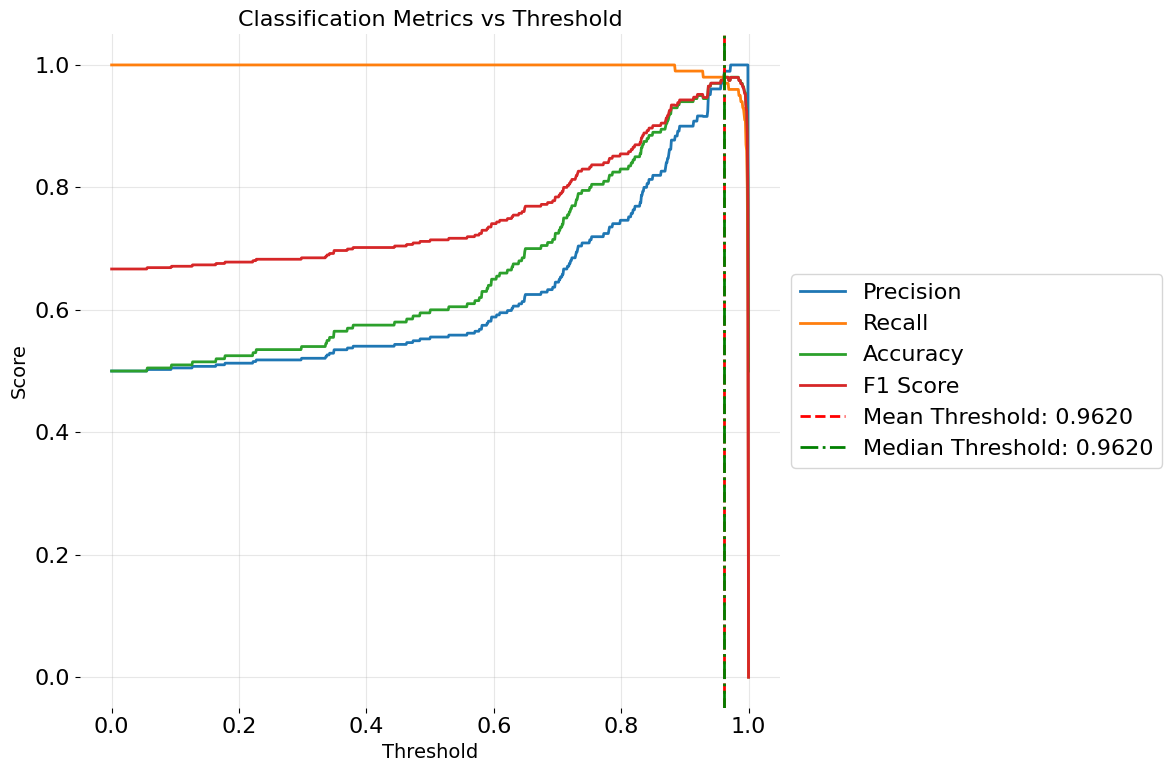


Metrics at Mean Threshold (0.9620):
  Precision: 0.9899
  Recall: 0.9794
  Accuracy: 0.9847
  F1 Score: 0.9846
   - Plotting threshold distribution...


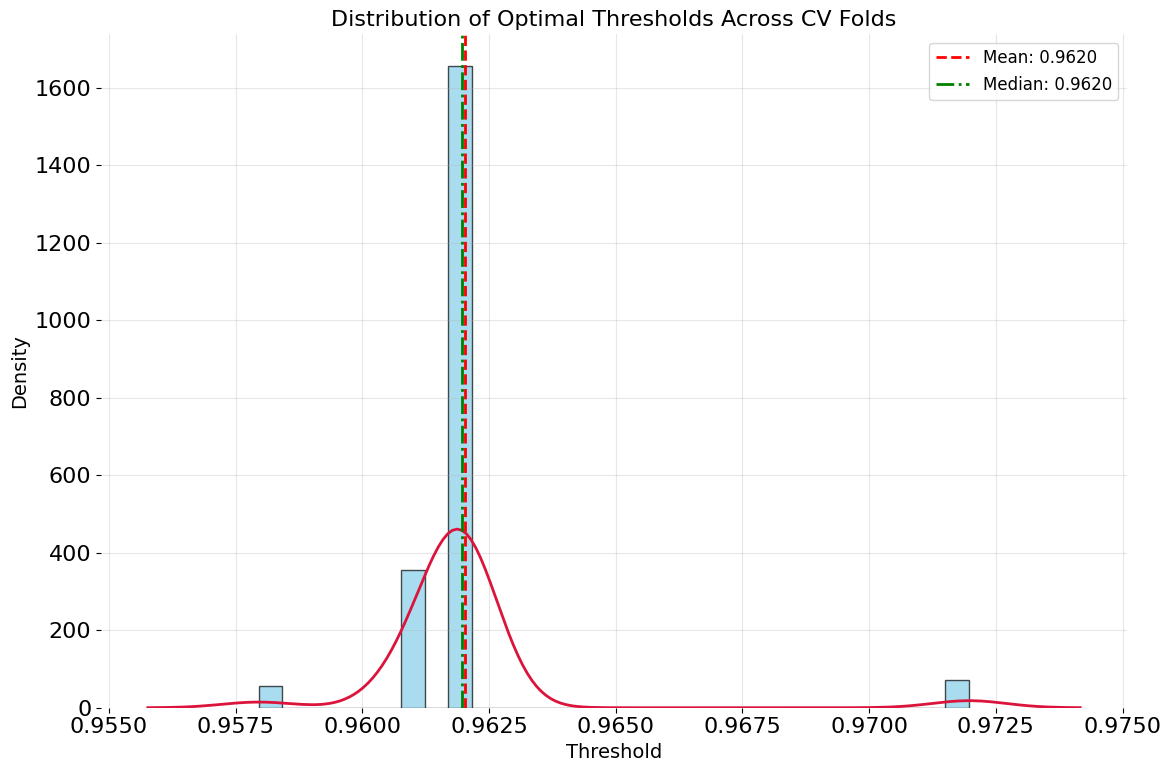


Threshold Distribution Statistics:
  Mean: 0.9620
  Median: 0.9620
  Standard Deviation: 0.0020
  5th Percentile: 0.9610
  95th Percentile: 0.9620
  Range: [0.9580, 0.9720]
   - Plotting ROC curve...


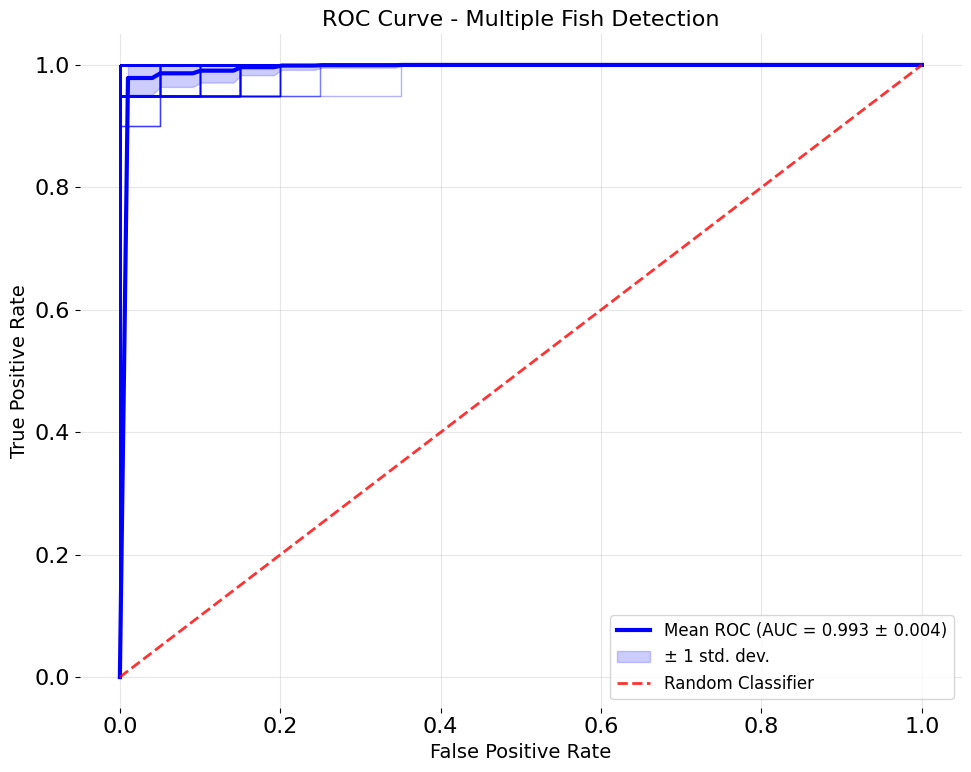


ROC Analysis:
  Mean AUC: 0.9927 ± 0.0038
  AUC Range: [0.9800, 1.0000]
   - Plotting confusion matrix...


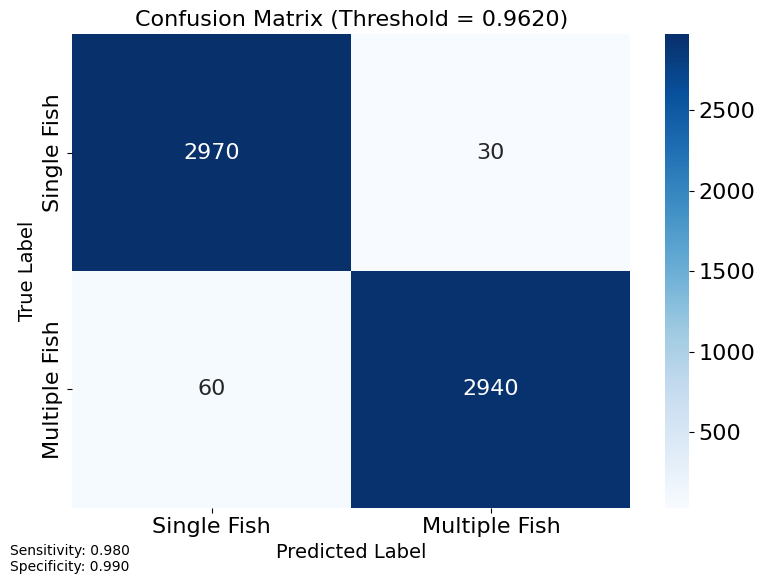


Confusion Matrix Analysis (Threshold = 0.9620):
  True Negatives: 2970
  False Positives: 30
  False Negatives: 60
  True Positives: 2940
  Sensitivity (Recall): 0.9800
  Specificity: 0.9900

6. Analyzing misclassifications...

Misclassification Analysis:
  Total samples: 200
  Misclassified: 3 (1.5%)
  False Positives: 1 (single fish → multiple fish)
  False Negatives: 2 (multiple fish → single fish)

False Positive Examples (showing up to 3):
  1. fish_frame_1500.jpg (confidence: 0.9711)

False Negative Examples (showing up to 3):
  1. fish_frame_1157.jpg (confidence: 0.8840)
  2. fish_frame_881.jpg (confidence: 0.9284)

FINAL SUMMARY
Model Performance:
  - Accuracy: 1.0% ± 0.0%
  - Precision: 1.0% ± 0.0%
  - Recall: 1.0% ± 0.0%
  - F1-Score: 1.0% ± 0.0%
  - Optimal Threshold: 0.9620

Error Analysis:
  - False Positives: 1 samples
  - False Negatives: 2 samples
  - Overall Error Rate: 1.5%

Cross-Validation Robustness:
  - 150 total evaluations
  - Consistent performance across fold

In [42]:
def main():
    """Main execution function for cross-validation evaluation"""
    print("=== Multi-Fish Detection: Cross-Validation and Threshold Optimization ===")
    print("Paper: Temporal Aggregation of Vision-Language Features for High-Accuracy Fish Classification")
    print()

    # Initialize model
    print("1. Initializing model...")
    model, preprocess_val, tokenizer = initialize_model()

    # Load data
    print("\n2. Loading dataset...")
    image_paths, labels = load_and_preprocess_data()

    if not image_paths:
        print("Error: No images found. Please update the data paths in load_and_preprocess_data()")
        return

    # Setup prompts and features
    print("\n3. Setting up optimized prompts...")
    text_features = setup_prompts_and_features(model, tokenizer, DEVICE)

    # Perform cross-validation
    print("\n4. Performing cross-validation evaluation...")
    mean_metrics, std_metrics, all_metrics, all_thresholds, all_true_labels, all_predictions = perform_cross_validation(
        image_paths, labels, model, text_features, preprocess_val, DEVICE
    )

    # Print results
    print("\n" + "="*60)
    print("CROSS-VALIDATION RESULTS")
    print("="*60)
    for metric_name in ['accuracy', 'precision', 'recall', 'f1']:
        print(f"{metric_name.capitalize():>12}: {mean_metrics[metric_name]:.4f} ± {std_metrics[metric_name]:.4f}")

    print(f"\nThreshold Statistics:")
    print(f"{'Mean Threshold':>12}: {np.mean(all_thresholds):.4f}")
    print(f"{'Std Threshold':>12}: {np.std(all_thresholds):.4f}")

    # Generate visualizations
    print("\n5. Generating visualizations...")

    print("   - Plotting metrics vs thresholds...")
    plot_metrics_vs_thresholds(all_true_labels, all_predictions, all_thresholds)

    print("   - Plotting threshold distribution...")
    plot_threshold_distribution(all_thresholds)

    print("   - Plotting ROC curve...")
    plot_roc_curve(all_true_labels, all_predictions)

    print("   - Plotting confusion matrix...")
    optimal_threshold = np.median(all_thresholds)
    plot_confusion_matrix(all_true_labels, all_predictions, optimal_threshold)

    # Analyze misclassifications
    print("\n6. Analyzing misclassifications...")
    false_positives, false_negatives = analyze_misclassifications(
        image_paths, labels, model, text_features, preprocess_val, DEVICE, optimal_threshold
    )

    # Final summary
    print("\n" + "="*60)
    print("FINAL SUMMARY")
    print("="*60)
    print(f"Model Performance:")
    print(f"  - Accuracy: {mean_metrics['accuracy']:.1f}% ± {std_metrics['accuracy']:.1f}%")
    print(f"  - Precision: {mean_metrics['precision']:.1f}% ± {std_metrics['precision']:.1f}%")
    print(f"  - Recall: {mean_metrics['recall']:.1f}% ± {std_metrics['recall']:.1f}%")
    print(f"  - F1-Score: {mean_metrics['f1']:.1f}% ± {std_metrics['f1']:.1f}%")
    print(f"  - Optimal Threshold: {optimal_threshold:.4f}")

    print(f"\nError Analysis:")
    print(f"  - False Positives: {len(false_positives)} samples")
    print(f"  - False Negatives: {len(false_negatives)} samples")
    print(f"  - Overall Error Rate: {(len(false_positives) + len(false_negatives))/len(image_paths)*100:.1f}%")

    print(f"\nCross-Validation Robustness:")
    print(f"  - {TOTAL_CV_ITERATIONS} total evaluations")
    print(f"  - Consistent performance across folds")
    print(f"  - Low standard deviation indicates stable model")

    print("\nAll visualizations saved as PNG files.")
    print("Cross-validation evaluation complete!")

    return {
        'mean_metrics': mean_metrics,
        'std_metrics': std_metrics,
        'all_thresholds': all_thresholds,
        'optimal_threshold': optimal_threshold,
        'false_positives': false_positives,
        'false_negatives': false_negatives
    }

if __name__ == "__main__":
    # Execute main function
    results = main()